## End member mixing analysis (EMMA) to determine streamflow source contributions

### EMMA Step #3: solving EMM models using SciPy sequential least squares quadratic optimization.​

#### This analysis starts from solute data from Hungerford Brook late winter/early spring flow events captured with ISCOs. Data include:
- base cations from ICP-OES measurements: Al, Ca, Cu, Fe, K, Mg, Mn, Na, P, Zn, Si
- base anions from IC measurements: Cl, F, Br (NO2, NO3, SO4 also from IC - I reject the PO4 from IC)
- nutrient concentrations from total elemental analyzer: SO4, NO3, PO4, DIN
- total organic carbon (TOC) from total elemental analyzer
- stable water isotopes (dD, d18O)

Data are all in the Winter Watershed OneDrive directory under Documents\Link to LCBP Data (Sharepoint)/LCBP_EMMA

- For HB and WB 2023 timeseries, 17 parameters total
- For HB, 5 were found to be relatively conservative: Cl, Ca, Na, Si, and Mg
- See EMMA Step #1 ["bivariates" notebook](https://github.com/MeganEDuffy/EMMA/blob/main/EMMA/Hungerford_2023_ISCO_bivariates.ipynb) and EMMA Step #2 [PCA notebook](https://github.com/MeganEDuffy/EMMA/blob/main/EMMA/Hungerford_2023_ISCO_PCA.ipynb) for the above work and figures. 
- This is a standalone script, it builds on EMMA Steps #1 and #2 but is run from the original data.

This code utilizes the minimize function from SciPy to find fractions that meet the specified constraints. The objective function minimizes the difference between the observed and predicted observations, subject to the constraints on the fractions.

### TO DO (last updated 2024-11-19):

- [ ] Adaptive endmember read in for event and site within single origin CSV
        - Function to read in EMs, normalize and do PCA, then EMMA and fractional cont balance

In [1]:
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

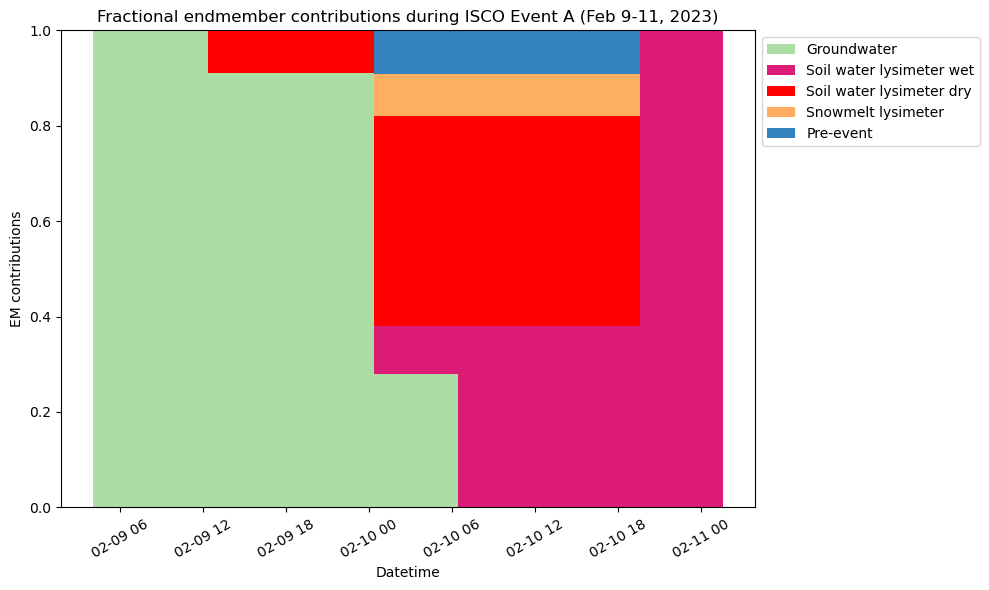

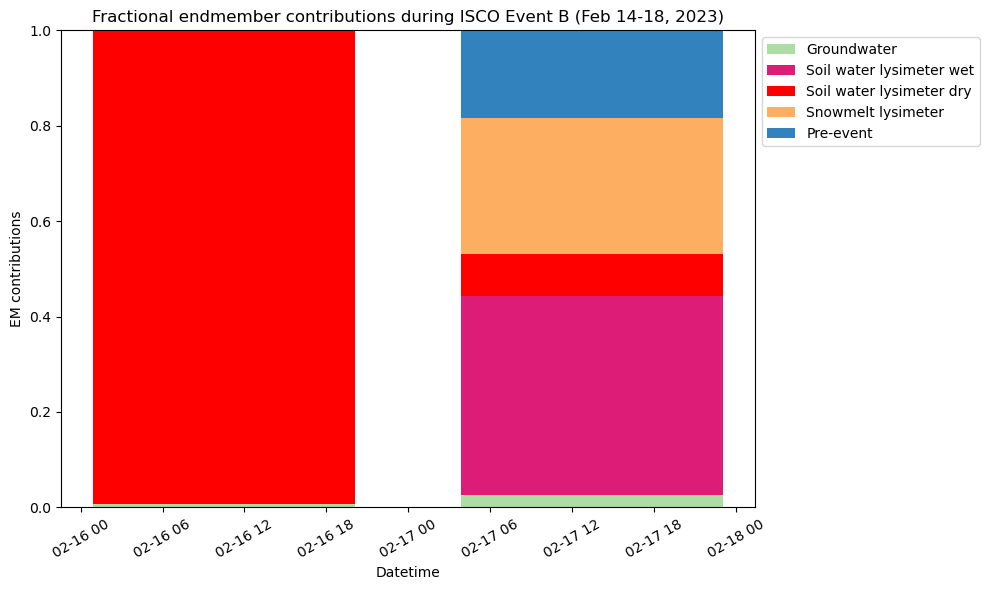

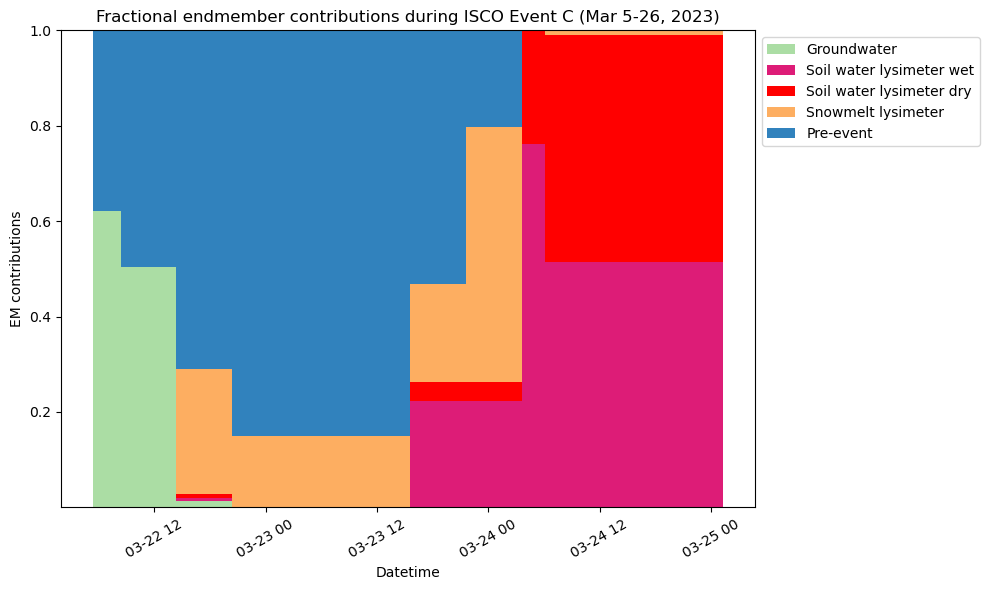

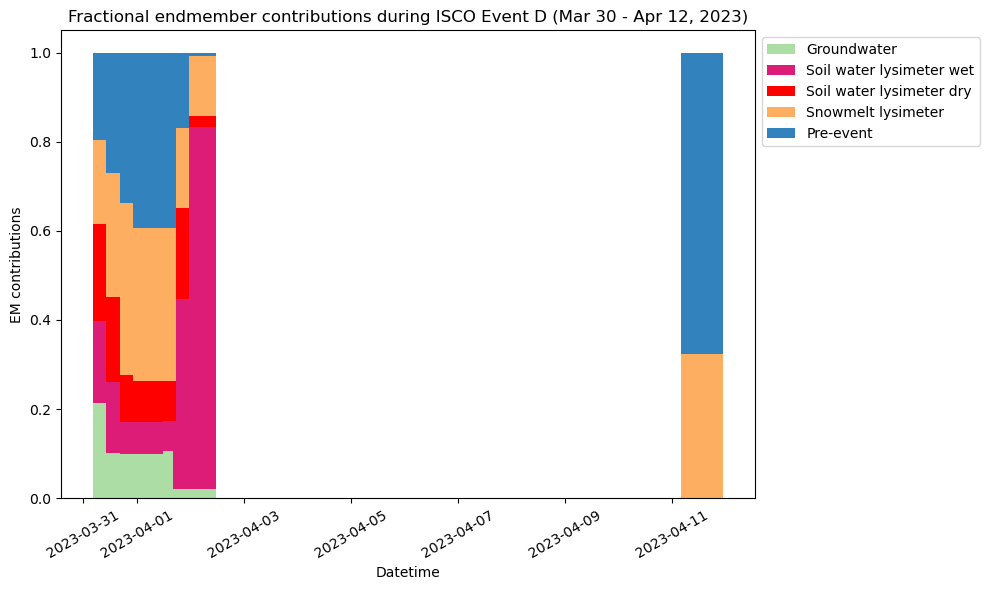

In [7]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Hungerford' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == "Hungerford") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Load the month-specific endmember data from the CSV file
em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-hford.csv")
em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

#########
# PCA  #
#########

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + selected_parameters]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=selected_parameters)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[selected_parameters]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/11/2023 00:00')]

# Filter data for samples in Event B
eventB_df = fractions_df[(fractions_df['Datetime'] >= '02/14/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/05/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventB_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', \
          'Soil water lysimeter wet': '#dd1c77', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61',\
          'Pre-event': '#3182bd' }

# Define a function to plot a stacked bar chart for an event
def plot_event(event_df, event_name, colors, figsize=(10, 6)):
    """
    Plots a stacked bar chart of fractional endmember contributions for a specific event.
    
    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - figsize: Tuple specifying figure size.
    """
    if event_df.empty:
        print(f"Warning: {event_name} has no data to plot.")
        return

    plt.figure(figsize=figsize)
    bottom = None

    # Iterate through the endmembers and stack their contributions
    for column, color in colors.items():
        plt.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    # Add plot labels and title
    plt.xlabel('Datetime')
    plt.ylabel('EM contributions')
    plt.title(f'Fractional endmember contributions during ISCO {event_name}')
    
    # Rotate x-axis tick labels for better readability
    plt.xticks(rotation=30)

    # Place the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Call the function for each event
plot_event(eventA_df, "Event A (Feb 9-11, 2023)", colors)
plot_event(eventB_df, "Event B (Feb 14-18, 2023)", colors)
plot_event(eventC_df, "Event C (Mar 22-26, 2023)", colors)
plot_event(eventD_df, "Event D (Mar 30 - Apr 12, 2023)", colors)

In [122]:
#############################
# In progess as of 2024-11-19
# Adaptive endmember call in

###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Hungerford' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == "Hungerford") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Define event-specific endmember files
event_endmember_files = {
    "Event A": "data/newrnet-chemistry/RI23-endmembers-february-hford.csv",
    "Event B": "data/newrnet-chemistry/RI23-endmembers-february-hford.csv",
    "Event C": "data/newrnet-chemistry/RI23-endmembers-february-hford.csv",
    "Event D": "data/newrnet-chemistry/RI23-endmembers-february-hford.csv"
}

# Define event date ranges
event_date_ranges = {
    "Event A": ('2023-02-09 00:00', '2023-02-12 00:00'),
    "Event B": ('2023-02-14 00:00', '2023-02-18 00:00'),
    "Event C": ('2023-03-05 00:00', '2023-03-26 00:00'),
    "Event D": ('2023-03-30 00:00', '2023-04-12 00:00')
}

# Define colors for endmembers
colors = {
    'Groundwater': '#abdda4',
    'Soil water lysimeter wet': '#dd1c77',
    'Soil water lysimeter dry': 'red',
    'Snowmelt lysimeter': '#fdae61',
    'Pre-event': '#3182bd'
}

# General function for PCA, EMMA, and plotting
def process_event(event_name, start_date, end_date, endmember_file, streamwater_data, selected_parameters, colors):
    """
    Perform PCA, EMMA, and plot results for a specific event.
    """
    # Filter streamwater data for the event
    event_data = streamwater_data[
        (streamwater_data['Datetime'] >= start_date) &
        (streamwater_data['Datetime'] <= end_date)
    ]
    if event_data.empty:
        print(f"Warning: {event_name} has no streamwater data in the specified date range.")
        return
    
    # Load event-specific endmember data
    em_data = pd.read_csv(endmember_file)
    em_data['Datetime'] = pd.to_datetime(em_data['Date'] + ' ' + em_data['Time'], format="%m/%d/%Y %H:%M", errors="coerce")
    em_data = em_data.dropna(subset=['Datetime'])

    # PCA for streamwater
    subset_streamwater = event_data[selected_parameters].dropna()
    scaler = StandardScaler()
    scaled_streamwater = scaler.fit_transform(subset_streamwater)
    pca_streamwater = PCA(n_components=2)
    pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

    # PCA for endmembers
    subset_endmembers = em_data[selected_parameters]
    scaler = StandardScaler()
    scaled_endmembers = scaler.fit_transform(subset_endmembers)
    pca_endmembers = PCA(n_components=2)
    pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

    # EMMA
    fractions = []
    for i in range(len(pca_result_streamwater)):
        pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)
        initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]
        result = minimize(
            objective_function, 
            initial_guess, 
            args=(pca_vector_streamwater, pca_result_endmembers),
            constraints=constraints, 
            method='SLSQP'
        )
        fractions.append(result.x)
    
    fractions = np.vstack(fractions)
    fractions_df = pd.DataFrame(fractions, columns=subset_endmembers.index)

    # Add identifying information
    fractions_df = pd.concat([event_data[['Datetime']].reset_index(drop=True), fractions_df], axis=1)
    fractions_df.set_index('Datetime', inplace=True)

    # Plot event
    plot_event(fractions_df, event_name, colors)

# Process each event
for event_name, date_range in event_date_ranges.items():
    process_event(
        event_name=event_name,
        start_date=date_range[0],
        end_date=date_range[1],
        endmember_file=event_endmember_files[event_name],
        streamwater_data=streamwater_data,
        selected_parameters=selected_parameters,
        colors=colors
    )


KeyError: 'Groundwater'

<Figure size 1000x600 with 0 Axes>

/tmp/ipykernel_26553/3985568243.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fractions_df['Sum Fractions'] = fractions_df.sum(axis=1)


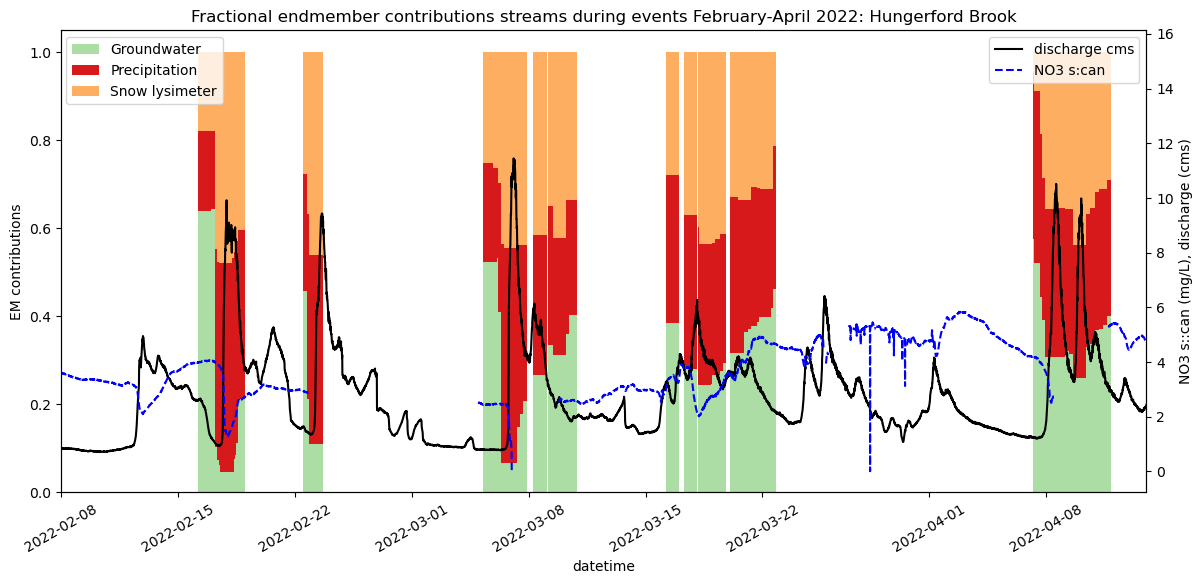

In [123]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load streamflow data from the CSV file
streamflow_data = pd.read_csv("data/newrnet-chemistry/Data_for_EMMA_2022_HB.csv")

# Load s::can NO3 and TP data from csv
scan_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/hb_q_chem copy.csv")

soil_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/EMMA/data/soil-sensor/Temperature.SoilTemp_15cm@HD_pit1.20210801.csv")

# Convert Date and Time strings to combined datetime that we'll index
streamflow_data['datetime'] = pd.to_datetime(streamflow_data['Date'] + ' ' + streamflow_data['Time'])

# Load potential endmembers from the separate CSV file
endmember_data = pd.read_csv("data/newrnet-chemistry/end_members_2022_HB_mean_for_emma.csv")

# Convert Date and Time strings to combined datetime that we'll index
endmember_data['datetime'] = pd.to_datetime(endmember_data['Date'] + ' ' + endmember_data['Time'])

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Standardize the endmember data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Apply PCA to streamflow data
pca_streamflow = PCA(n_components=2)
pca_result_streamflow = pca_streamflow.fit_transform(scaler.transform(streamflow_data[selected_parameters]))

# Function to calculate the objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

# Solve for fractions using optimization
fractions = []

for i in range(len(streamflow_data)):
    # Extract PCA vector for the current streamflow sample
    pca_vector_streamflow = pca_result_streamflow[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamflow, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the information
fractions_df = pd.DataFrame(fractions, columns=endmember_data['Type'])
fractions_df['Sample ID'] = streamflow_data['Sample ID']
fractions_df['Date'] = streamflow_data['Date']
fractions_df['Time'] = streamflow_data['Time']
fractions_df['Sum Fractions'] = fractions_df.sum(axis=1)

# Convert Date and Time strings to combined datetime that we'll index
fractions_df['datetime'] = pd.to_datetime(fractions_df['Date'] + ' ' + fractions_df['Time'])

# Aggregate nitrate data for each date (using mean as an example)
nitrate_data_agg = streamflow_data.groupby('datetime')['NO3_mg_L'].mean().reset_index()
nitrate_scan_agg = scan_data.groupby('datetime')['NO3'].mean().reset_index()

# Convert 'Date' column to datetime if it's not already
nitrate_data_agg['datetime'] = pd.to_datetime(nitrate_data_agg['datetime'])
nitrate_scan_agg['datetime'] = pd.to_datetime(nitrate_scan_agg['datetime'])
scan_data['datetime'] = pd.to_datetime(scan_data['datetime'])

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)

# Convert the timezone-aware datetime to timezone-naive
soil_data['ISO 8601 UTC'] = pd.to_datetime(soil_data['ISO 8601 UTC']).dt.tz_convert(None)

# Merge aggregated nitrate data with fractions_df on 'Date'
event1_df = pd.concat([fractions_df.set_index('datetime'), nitrate_data_agg.set_index('datetime')], axis=1)
#event1_df = pd.concat([fractions_df.set_index('datetime'), scan_data.set_index('datetime')], axis=1)

# Set 'datetime' as the index
event1_df.reset_index(inplace=True)

# Set 'datetime' as the index
event1_df.set_index('datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', 'Precipitation': '#d7191c', 'Snow lysimeter': '#fdae61'}

# Plot stacked bar chart
fig, ax1 = plt.subplots(figsize=(14, 6))

bottom = None
for column, color in colors.items():
    ax1.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    if bottom is None:
        bottom = event1_df[column].values
    else:
        bottom += event1_df[column].values

ax1.set_xlabel('datetime')
ax1.set_ylabel('EM contributions')
ax1.set_title('Fractional endmember contributions streams during events February-April 2022: Hungerford Brook')

# Set x-axis limits
start_date = pd.to_datetime("2022-02-08 00:00:00")
end_date = pd.to_datetime("2022-04-14 00:00:00")
ax1.set_xlim([start_date, end_date])

# Rotate x-axis tick labels
plt.xticks(rotation=30)

# Place legend outside the plot on the left
ax1.legend(loc='upper right', bbox_to_anchor=(0.155, 1))

# Create a secondary y-axis for nitrate concentration
ax2 = ax1.twinx()
#ax2.plot(event1_df.index, event1_df['NO3_mg_L'], color='blue', label='NO3_mg_L', linestyle='--')
ax2.plot(scan_data['datetime'], scan_data['q_cms_hb'], color='black', label='discharge cms', linestyle='-')
ax2.plot(nitrate_scan_agg['datetime'], nitrate_scan_agg['NO3'], color='blue', label='NO3 s:can', linestyle='--')
#ax2.plot(soil_data['ISO 8601 UTC'], soil_data['Value'], color='red', label='15 cm soil temp', linestyle='--')
ax2.set_ylabel('NO3 s::can (mg/L), discharge (cms)', color='black')
ax2.legend(loc='upper right')

plt.show()

In [16]:
ax1 = fractions_df.plot.scatter(x='length',

                      y='width',

                      c='DarkBlue')

,Precipitation,Snow lysimeter,Groundwater,Sample ID,Date,Time,Sum Fractions,NO3_mg_L
datetime,,,,,,,,
2022-02-16 13:45:00,0.181685,0.180016,1.0,RI22-0254,2/16/22,13:45,1.0,16.0256
2022-02-17 02:00:00,0.179697,0.153324,1.0,RI22-0258,2/17/22,2:00,1.0,15.7620
2022-02-17 06:00:00,0.178897,0.178336,1.0,RI22-0259,2/17/22,6:00,1.0,15.6664
2022-02-17 10:00:00,0.182969,0.150179,1.0,RI22-0260,2/17/22,10:00,1.0,14.5401
2022-02-17 14:00:00,0.451746,0.446546,1.0,RI22-0110,2/17/22,14:00,1.0,6.0423
...,...,...,...,...,...,...,...,...
2022-04-10 12:00:00,0.307820,0.354863,1.0,RI22-0793,4/10/22,12:00,1.0,18.4550
2022-04-10 18:00:00,0.314265,0.316842,1.0,RI22-0794,4/10/22,18:00,1.0,19.0450
2022-04-11 00:00:00,0.319331,0.310810,1.0,RI22-0795,4/11/22,0:00,1.0,16.9498


In [37]:
event1_df

,Precipitation,Snow lysimeter,Groundwater,Sample ID,Date,Time,Sum Fractions,NO3_mg_L
datetime,,,,,,,,
2022-02-16 13:45:00,0.181685,0.180016,1.0,RI22-0254,2/16/22,13:45,1.0,16.0256
2022-02-17 02:00:00,0.179697,0.153324,1.0,RI22-0258,2/17/22,2:00,1.0,15.7620
2022-02-17 06:00:00,0.178897,0.178336,1.0,RI22-0259,2/17/22,6:00,1.0,15.6664
2022-02-17 10:00:00,0.182969,0.150179,1.0,RI22-0260,2/17/22,10:00,1.0,14.5401
2022-02-17 14:00:00,0.451746,0.446546,1.0,RI22-0110,2/17/22,14:00,1.0,6.0423
...,...,...,...,...,...,...,...,...
2022-04-10 12:00:00,0.307820,0.354863,1.0,RI22-0793,4/10/22,12:00,1.0,18.4550
2022-04-10 18:00:00,0.314265,0.316842,1.0,RI22-0794,4/10/22,18:00,1.0,19.0450
2022-04-11 00:00:00,0.319331,0.310810,1.0,RI22-0795,4/11/22,0:00,1.0,16.9498


In [10]:
###################
# SET DIRECTORIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the data from the CSV file
data = pd.read_csv("data/newrnet-chemistry/RI23-IC-ICP-isotope-joined.csv")

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Convert the "Date" column to datetime
#streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")

# Load the month-specific endmember data from the CSV file
em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv")

# Convert the "Date" column to datetime
em_data["Date"] = pd.to_datetime(em_data["Date"], format="%m/%d/%Y", errors="coerce")

# Load the potential endmembers from the same csv
endmember_data = em_data#.loc[
    #(data['Site'] == "Wade") #& 
    #(data['Type'].isin(['Snow', 'Rain', 'Baseflow', 'Groundwater', \
                        #'Soil water lysimeter', 'Snowmelt lysimeter',\
                       #'DM', 'Precip', 'Fake baseflow']))
#]

# Convert the "Date" column to datetime in the endmember data
#endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y")

###########################################
# Separate data based on month or events #
# Asign markers to endmember types       #    
###########################################

# Define date ranges and corresponding colors for streamwater data
streamwater_date_ranges = {
    "Jan": ("2023-01-01", "2023-01-31", "#d7191c"),  # Red
    "Feb": ("2023-02-01", "2023-02-28", "#fdae61"),  # Orange
    "Mar": ("2023-03-01", "2023-03-31", "#abdda4"),  # Light Green
    "Apr": ("2023-04-01", "2023-04-30", "#2b83ba")   # Blue
}

# Define colors for each event
event_colors = {'Jan': 'blue', 'Feb': 'blue', 'Mar': 'blue', 'Apr': 'blue'}

# Define markers for endmember types
endmember_markers = {'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',\
                     'Soil water lysimeter': '<', 'Groundwater': 'D', 'DM': '>', 'Baseflow': '+'}

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_streamwater = streamwater_data[selected_parameters]

# For PCA, dropping rows where there are NaN data (just for subset)
subset_streamwater = subset_streamwater.dropna(how='any')    #to drop if any value in the row has a nan

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Handle missing values in endmembers (replace with mean)
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())

# Standardize the endmember data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
#scaled_endmembers = scaler.transform(subset_endmembers) # need this too? MED 2024-11-08

#########
# PCA  #
#########

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(subset_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for an EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)
pca_2Dresult_streamwater.to_csv("output/pca_result_streamwater.csv", index=False, header=True)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)


#########
# EMMA  #
#########

# Function to calculate the objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

# Align loop bounds with the PCA result instead of `streamwater_data`
fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)
    
# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the information
fractions_df = pd.DataFrame(fractions, columns=endmember_data['Type'])
fractions_df['Sample ID'] = streamwater_data['Sample ID']
fractions_df['Date'] = streamwater_data['Date']
fractions_df['Time'] = streamwater_data['Time']
fractions_df['Sum Fractions'] = fractions_df.sum(axis=1)

# Convert Date to string, then concatenate with Time to create a combined datetime string
#fractions_df['Datetime'] = pd.to_datetime(fractions_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + fractions_df['Time'])
fractions_df['Datetime'] = pd.to_datetime(fractions_df['Date'] + ' ' + fractions_df['Time'])

# Now, 'Datetime' is properly formatted as a datetime object
fractions_df.head(100)

/tmp/ipykernel_103697/3974738313.py:146: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fractions_df['Sum Fractions'] = fractions_df.sum(axis=1)


Type,Soil water lysimeter dry,Snowmelt lysimeter,Groundwater,Groundwater,Fake baseflow,Fake baseflow,Sample ID,Date,Time,Sum Fractions,Datetime
0,8.260566e-15,5.764772e-01,-5.733897e-14,-6.524467e-14,-6.418353e-14,4.235228e-01,NaN,NaN,NaN,1.0,NaT
1,1.540051e-14,4.094568e-01,3.666636e-14,3.589725e-14,1.096894e-14,5.905432e-01,NaN,NaN,NaN,1.0,NaT
2,1.306172e-14,3.638174e-01,3.243523e-14,3.577646e-14,2.920417e-15,6.361826e-01,NaN,NaN,NaN,1.0,NaT
3,5.438676e-16,-1.928924e-16,1.751150e-01,3.213138e-15,-5.127517e-16,8.248850e-01,ISO23-160,02/22/2023,11:30:00 AM,1.0,2023-02-22 11:30:00
4,-3.829422e-16,4.556031e-16,1.826896e-01,6.285267e-16,1.086859e-15,8.173104e-01,NaN,NaN,NaN,1.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...
60,8.787916e-16,-6.701418e-16,6.010477e-01,1.485805e-15,-1.226107e-15,3.989523e-01,RI23-1055,3/23/2023,12:00,1.0,2023-03-23 12:00:00
61,-5.525903e-16,-3.992773e-16,6.627495e-01,-3.413535e-16,-4.179547e-16,3.372505e-01,RI23-1056,3/23/2023,18:00,1.0,2023-03-23 18:00:00
62,1.699972e-15,4.284324e-16,7.451646e-01,-1.614713e-15,1.292449e-15,2.548354e-01,RI23-1057,3/24/2023,0:00,1.0,2023-03-24 00:00:00
63,-1.385378e-15,4.953579e-15,7.527371e-01,1.482633e-14,-1.626121e-15,2.472629e-01,RI23-1058,3/24/2023,6:00,1.0,2023-03-24 06:00:00


In [11]:
streamwater_data

,Sample ID,Site,Date,Time,Type,Index-notes,ICP-notes,Fe_mg_L,Mn_mg_L,Cu_mg_L,...,NO2_mg_L,Br_mg_L,NO3_mg_L,PO4_mg_L,SO4_mg_L,IC-notes,NRS_LWIA_notes,dD,d18O,iso-notes
3,ISO23-160,Wade,02/22/2023,11:30:00 AM,Grab,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-78.887,-11.042,NaN
7,ISO23-165,Wade,01/24/2023,12:00:00 PM,Baseflow,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-76.707,-11.481,NaN
13,RI23-1006,Wade,2/10/2023,13:00,Grab/Isco,need to verify type,NaN,NaN,NaN,NaN,...,NaN,NaN,2.633325,1.593013,6.720394,2024-10-03 MED switched SO4 and PO4 values bec...,NaN,-80.253,-12.024,NaN
16,RI23-1009,Wade,2/15/2023,15:00,Grab/Isco,need to verify type,NaN,-0.000368,-0.013919,0.000669,...,NaN,NaN,2.365148,NaN,8.192964,2024-10-03 MED switched SO4 and PO4 values bec...,NaN,-78.421,-11.844,NaN
17,RI23-1010,Wade,2/15/2023,19:00,Grab/Isco,need to verify type,NaN,0.015831,-0.000335,-0.001384,...,NaN,NaN,2.337741,NaN,8.039080,2024-10-03 MED switched SO4 and PO4 values bec...,NaN,-78.932,-11.876,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,RI23-1096,Wade,4/11/2023,0:00,Grab/Isco,need to verify type,NaN,0.009030,-0.000674,-0.001201,...,NaN,NaN,2.074700,2.162000,2.836600,NaN,vial is missing,NaN,NaN,NaN
111,RI23-1097,Wade,4/11/2023,6:00,Grab/Isco,need to verify type,NaN,-0.005309,-0.015565,-0.000003,...,0.5776,NaN,2.248200,NaN,2.897800,NaN,NaN,-86.183,-12.693,NaN
114,RI23-1100,Wade,4/11/2023,16:00,Grab/Isco,need to verify type,NaN,-0.003003,-0.015022,0.000547,...,NaN,NaN,2.556606,1.595330,5.863017,2024-10-03 MED switched SO4 and PO4 values bec...,NaN,-86.889,-12.713,NaN
115,RI23-1101,Wade,4/12/2023,0:00,Grab/Isco,need to verify type,NaN,0.005326,-0.014964,0.000661,...,0.5757,NaN,2.466900,NaN,2.499700,NaN,NaN,-88.178,-12.949,NaN


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (14,) and arg 1 with shape (14, 2).

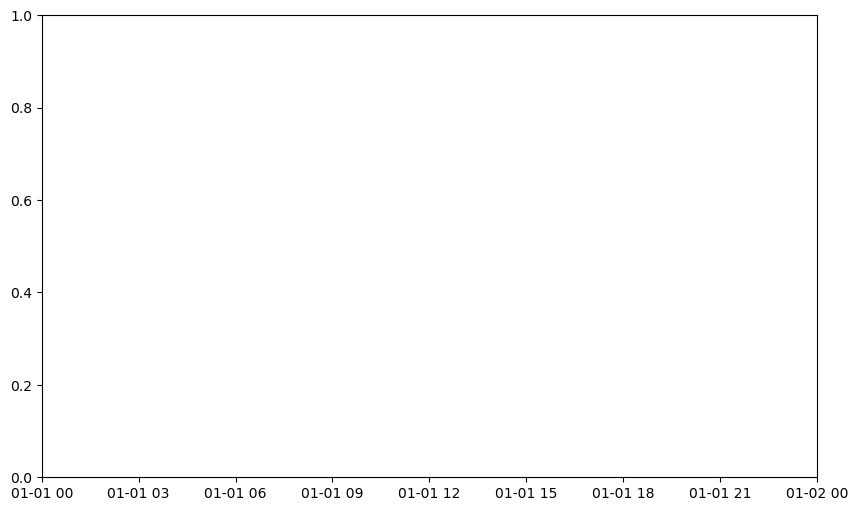

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# fractions_df = ... see above

# Filter data for samples in Event A & 'A.5'
event1_df = fractions_df[(fractions_df['Datetime'] >= '2023-03-22 00:00:00') & (fractions_df['Datetime'] <= '2023-04-18 00:00:00')]

# Set 'Datetime' as the index
event1_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', 'Soil water lysimeter dry': '#d7191c', \
          'Soil water lysimeter wet': '#f768a1', 'Snowmelt lysimeter 3/28': '#fdae61', \
          'Snowmelt lysimeter 4/12': '#ae017e', 'Pre-event': '#3690c0', 'Precip': '#41b6c4'}

# Plot stacked bar chart
plt.figure(figsize=(10, 6))

bottom = None
for column, color in colors.items():
    plt.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    if bottom is None:
        bottom = event1_df[column].values
    else:
        bottom += event1_df[column].values

plt.xlabel('Datetime')
plt.ylabel('EM contributions')
plt.title('Hungerford endmember contributions in ISCO freshet events Mar 09-11; 15-16, 2023')

# Rotate x-axis tick labels
plt.xticks(rotation=30)

# Place legend outside the plot on the left
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()